In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
import pickle
from imp import reload
from os.path import join
from itertools import product

from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from data_loader import DataLoader
import medim
reload(medim);

In [2]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

n_classes = 3

In [3]:
processed_path = '/mount/export/Brats2017/data/processed'
mscans = []
msegms = []

for patient in tqdm(patients):
    filename = join(processed_path, patient)
    
    mscans.append(np.load(filename+'_mscan.npy'))
    msegms.append(np.load(filename+'_segmentation.npy'))

100%|██████████| 285/285 [00:26<00:00,  6.44it/s]


In [4]:
n_splits = 5

cv = KFold(n_splits, shuffle=True, random_state=42)
train, test = next(cv.split(mscans))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_train, mscans_test = extract(mscans, train), extract(mscans, test)
msegms_train, msegms_test = extract(msegms, train), extract(msegms, test)

In [5]:
n_splits = 40

cv = KFold(n_splits, shuffle=True, random_state=21)
train, val = next(cv.split(mscans_train))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_train, mscans_val = extract(mscans_train, train), extract(mscans_train, val)
msegms_train, msegms_val = extract(msegms_train, train), extract(msegms_train, val)

In [6]:
def dice_score(y_pred, target):
    """Dice score for binary segmentation on 3d scan"""
    dcs = 2 * np.sum(y_pred * target) / (np.sum(y_pred) + np.sum(target))
    if np.isnan(dcs):
        return 1
    else:
        return dcs

In [7]:
kernel_size = 3
blocks = [32, 32, 64, 64]

patch_size_x = np.array([25, 25, 25])
patch_size_y = patch_size_x - 2*len(blocks)

In [8]:
%%time

padding = (patch_size_x - patch_size_y) // 2

shapes = np.max(list(map(np.shape, mscans_val)), axis=0)[1:]
shapes


def min_padding(mscan, padding):
    padding = np.array([0] + list(padding))
    padding = np.repeat(padding[:, None], 2, axis=1)
    
    return np.pad(mscan, padding, mode='minimum')

mscans_val_padded = [np.pad(m, [(0, 0)] + list(zip(padding, padding + shapes - np.array(m.shape[1:]))), mode='minimum') for m in mscans_val]
msegms_val_padded = [np.pad(msegms_val[i], [(0, 0)] + list(zip(np.zeros_like(padding), shapes - np.array(msegms_val[i].shape[1:]))), mode='minimum') for i in range(len(mscans_val))]

CPU times: user 932 ms, sys: 4.16 s, total: 5.1 s
Wall time: 5.09 s


In [9]:
def combine_fast(parts):
    parts = [p.reshape(parts[0].shape[0], -1) for p in parts]
    return np.concatenate(parts, axis=1)

In [14]:
def to_var(x, volatile=False):
    return Variable(torch.from_numpy(x), volatile=volatile).cuda()

def to_numpy(x):
    return np.array(x.cpu().data.numpy())


def cb(in_chans, out_chans, kernel_size, relu=False):
    c = nn.Conv3d(in_chans, out_chans, kernel_size, bias=False)
    bn = nn.BatchNorm3d(out_chans)
    
    ops = [c, bn]
    if relu:
        ops.append(nn.ReLU(inplace=True))
    
    return nn.Sequential(*ops)

class ResBlock(nn.Module):
    def __init__(self, in_chans, int_chans, out_chans, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.in_chans = in_chans
        self.int_chans = int_chans
        self.out_chans = out_chans
        
        self.fe = nn.Sequential(
            cb(in_chans, int_chans, 1, relu=True),
            cb(int_chans, int_chans, kernel_size, relu=True),
            cb(int_chans, out_chans, 1),
        )
        
        if in_chans != out_chans:
            self.transformer = cb(in_chans, out_chans, 1)
    
    def forward(self, input):
        out = self.fe(input)
        
        s = self.kernel_size // 2
        if self.in_chans != self.out_chans:
            out += self.transformer(input[:, :, s:-s, s:-s, s:-s])
        else:
            out += input[:, :, s:-s, s:-s, s:-s]
        
        return F.relu(out, inplace=True)
        

class Model(torch.nn.Module):
    def __init__(self, blocks, kernel_size):
        super().__init__()
            
        fe = []
        n_chans_prev = 4
        for n_chans in blocks:
            fe.append(ResBlock(n_chans_prev, n_chans//4, n_chans, kernel_size))
            n_chans_prev = n_chans
            
        fe.extend([cb(n_chans_prev, n_classes, 1, relu=False),
                   nn.Sigmoid()])
        
        self.model = nn.Sequential(*fe)
    
    def forward(self, input):
        return self.model(input)
    
model = Model(blocks, kernel_size).cuda()

In [15]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)

In [16]:
n_parts = [1, 2, 1]

n_epoch = 100
batch_per_epoch = 40
batch_size = 128

for epoch in range(n_epoch):
    train_iter = medim.batch_iter.patch.uniform(
        mscans_train, msegms_train, batch_size=batch_size,
        patch_size_x=patch_size_x, patch_size_y=patch_size_y, 
    )
    
    start_train = time.time()
    
    model.train()
    losses = []
    for _ in tqdm(range(batch_per_epoch)):
        x_batch, y_batch = next(train_iter)

        y_pred = model(to_var(x_batch))

        optimizer.zero_grad()
        loss = F.binary_cross_entropy(y_pred, to_var(y_batch))

        loss.backward()
        optimizer.step()

        losses.append(to_numpy(loss))
    
    end_train = time.time()
    train_loss = np.mean(losses)
    
    print('Epoch {}'.format(epoch))
    print('Train:', train_loss, flush=True)
    
    start_val = time.time()
    
    model.eval()
    losses = []
    dices = []

    for mscan, msegm in tqdm(zip(mscans_val_padded, msegms_val_padded)):
        msegm = np.array(msegm, dtype=np.float32)

        mscan_parts = medim.utils.divide(mscan, padding, n_parts)
        msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

        predicted = []
        true = []
        for mscan_part, msegm_part in zip(mscan_parts, msegm_parts):
            o = np.array(mscan_part[None, :])

            y_pred = model(to_var(o, volatile=True))
            loss = F.binary_cross_entropy(y_pred, to_var(msegm_part[None, :], volatile=True))
            losses.append(to_numpy(loss))

            predicted.append(to_numpy(y_pred)[0])
            true.append(msegm_part)
    
        y_pred = combine_fast(predicted)
        y_true = combine_fast(true)
        
        dices.append([dice_score(y_pred[k] > 0.5, y_true[k]) for k in range(n_classes)])
    
    end_val = time.time()
    
    val_loss = np.mean(losses)
    val_dices = np.mean(dices, axis=0)

    print('Val  :', val_loss)
    print('Val  :', val_dices)
    print('Time :', end_train - start_train, end_val - start_val)
    print('\n', flush=True)

100%|██████████| 40/40 [00:33<00:00,  1.22it/s]

Epoch 0
Train: 0.609765



6it [00:04,  1.43it/s]

Val  : 0.458979
Val  : [ 0.5838664   0.34303138  0.19720412]
Time : 33.11899757385254 4.204025745391846





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 1
Train: 0.401357



6it [00:04,  1.43it/s]

Val  : 0.326561
Val  : [ 0.65930584  0.4677065   0.29551672]
Time : 32.92432928085327 4.186208486557007





100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

Epoch 2
Train: 0.293034



6it [00:04,  1.43it/s]

Val  : 0.241041
Val  : [ 0.7210003   0.43465757  0.40861822]
Time : 32.72567009925842 4.199462175369263





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 3
Train: 0.2326



6it [00:04,  1.44it/s]

Val  : 0.194218
Val  : [ 0.73890419  0.42919533  0.4266719 ]
Time : 32.675182819366455 4.181135654449463





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 4
Train: 0.18907



6it [00:04,  1.43it/s]

Val  : 0.161074
Val  : [ 0.7563602   0.46051721  0.46079953]
Time : 32.74704909324646 4.201280355453491





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 5
Train: 0.161566



6it [00:04,  1.43it/s]

Val  : 0.1381
Val  : [ 0.75178925  0.49071981  0.42298565]
Time : 32.6644127368927 4.194660663604736





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 6
Train: 0.141765



6it [00:04,  1.43it/s]

Val  : 0.121656
Val  : [ 0.75705882  0.54263529  0.46749418]
Time : 32.70324182510376 4.190408945083618





100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

Epoch 7
Train: 0.126695



6it [00:04,  1.43it/s]

Val  : 0.109941
Val  : [ 0.7466479   0.51397269  0.42344883]
Time : 32.71854114532471 4.192827939987183





100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

Epoch 8
Train: 0.120102



6it [00:04,  1.43it/s]

Val  : 0.0976141
Val  : [ 0.77671584  0.58000785  0.47611288]
Time : 32.7253258228302 4.197567701339722





100%|██████████| 40/40 [00:32<00:00,  1.22it/s]

Epoch 9
Train: 0.108258



6it [00:04,  1.43it/s]

Val  : 0.089525
Val  : [ 0.75389614  0.60658505  0.45428152]
Time : 32.72996735572815 4.191136360168457





 20%|██        | 8/40 [00:06<00:26,  1.22it/s]


KeyboardInterrupt: 

In [12]:
n_parts = [1, 2, 1]

n_epoch = 100
batch_per_epoch = 40
batch_size = 128

for epoch in range(n_epoch):
    train_iter = medim.batch_iter.patch.uniform(
        mscans_train, msegms_train, batch_size=batch_size,
        patch_size_x=patch_size_x, patch_size_y=patch_size_y, 
    )
    
    start_train = time.time()
    
    losses = []
    for _ in tqdm(range(batch_per_epoch)):
        x_batch, y_batch = next(train_iter)
    
    end_train = time.time()
    train_loss = np.mean(losses)
    
    print('Epoch {}'.format(epoch), flush=True)
    
    start_val = time.time()
    
    losses = []
    dices = []

    for mscan, msegm in zip(mscans_val_padded, msegms_val_padded):
        msegm = np.array(msegm, dtype=np.float32)

        mscan_parts = medim.utils.divide(mscan, padding, n_parts)
        msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

        predicted = []
        true = []
        for mscan_part, msegm_part in tqdm(zip(mscan_parts, msegm_parts)):
            o = np.array(mscan_part[None, :])

            y_pred = np.array(msegm_part)

            predicted.append(y_pred)
            true.append(msegm_part)
    
        y_pred = combine_fast(predicted)
        y_true = combine_fast(true)
        
        #dices.append([dice_score(y_pred[k] > 0.5, y_true[k]) for k in range(n_classes)])
    
    end_val = time.time()
    
    val_loss = np.mean(losses)
    val_dices = np.mean(dices, axis=0)

    print('Time :', end_train - start_train, end_val - start_val)
    print('\n', flush=True)

 15%|█▌        | 6/40 [00:03<00:16,  2.01it/s]


KeyboardInterrupt: 

In [25]:
y_preds = []

model.eval()
for mscan, msegm in tqdm(zip(mscans_val_padded, msegms_val)):
    msegm = np.array(msegm, dtype=np.float32)

    mscan_parts = medim.utils.divide(mscan, padding, n_parts)
    msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

    predicted = []
    for mscan_part, msegm_part in zip(mscan_parts, msegm_parts):
        o = np.array(mscan_part[None, :])

        y_pred = model(to_var(o, volatile=True))
        loss = F.binary_cross_entropy(y_pred, to_var(msegm_part[None, :], volatile=True))
        
        predicted.append(to_numpy(y_pred)[0])

    y_pred = medim.utils.combine(predicted, n_parts)
    y_preds.append(y_pred)

6it [00:16,  2.80s/it]


In [73]:
def get_dice_threshold(y_preds, msegms):
    thresholds = []
    for i in range(n_classes):
        ps = np.linspace(0, 1, 100)
        best_p = 0
        best_score = 0
        for p in ps:
            score = np.mean([dice_score(pred[i] > p, true[i]) for pred, true in zip(y_preds, msegms)])
            if score is np.nan or None:
                print('None')
                score = 1
            
            if score > best_score:
                best_p = p
                best_score = score
        thresholds.append(best_p)
        print(best_score)
    return thresholds

thresholds = get_dice_threshold(y_preds, msegms_val)
thresholds

0.826240742506
0.752797255717


/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


0.52705957917


[0.39393939393939398, 0.24242424242424243, 0.27272727272727276]

In [37]:
y_preds_t = []

model.eval()
for mscan, msegm in tqdm(zip(mscans_test, msegms_test)):
    mscan = min_padding(mscan, padding)
    msegm = np.array(msegm, dtype=np.float32)

    mscan_parts = medim.utils.divide(mscan, padding, n_parts)
    msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

    predicted = []
    for mscan_part, msegm_part in zip(mscan_parts, msegm_parts):
        o = np.array(mscan_part[None, :])

        y_pred = model(to_var(o, volatile=True))
        loss = F.binary_cross_entropy(y_pred, to_var(msegm_part[None, :], volatile=True))
        
        predicted.append(to_numpy(y_pred)[0])

    y_pred = medim.utils.combine(predicted, n_parts)
    y_preds_t.append(y_pred)

57it [11:18, 11.80s/it]


In [74]:
np.mean([[dice_score(y_preds_t[i][k] > thresholds[k], msegms_test[i][k]) for k in range(n_classes)]
         for i in range(len(y_preds_t))], axis=0)

/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


array([ 0.81615617,  0.6933758 ,  0.66851959])

In [75]:
len(mscans_train), len(mscans_val), len(mscans_test)

(222, 6, 57)

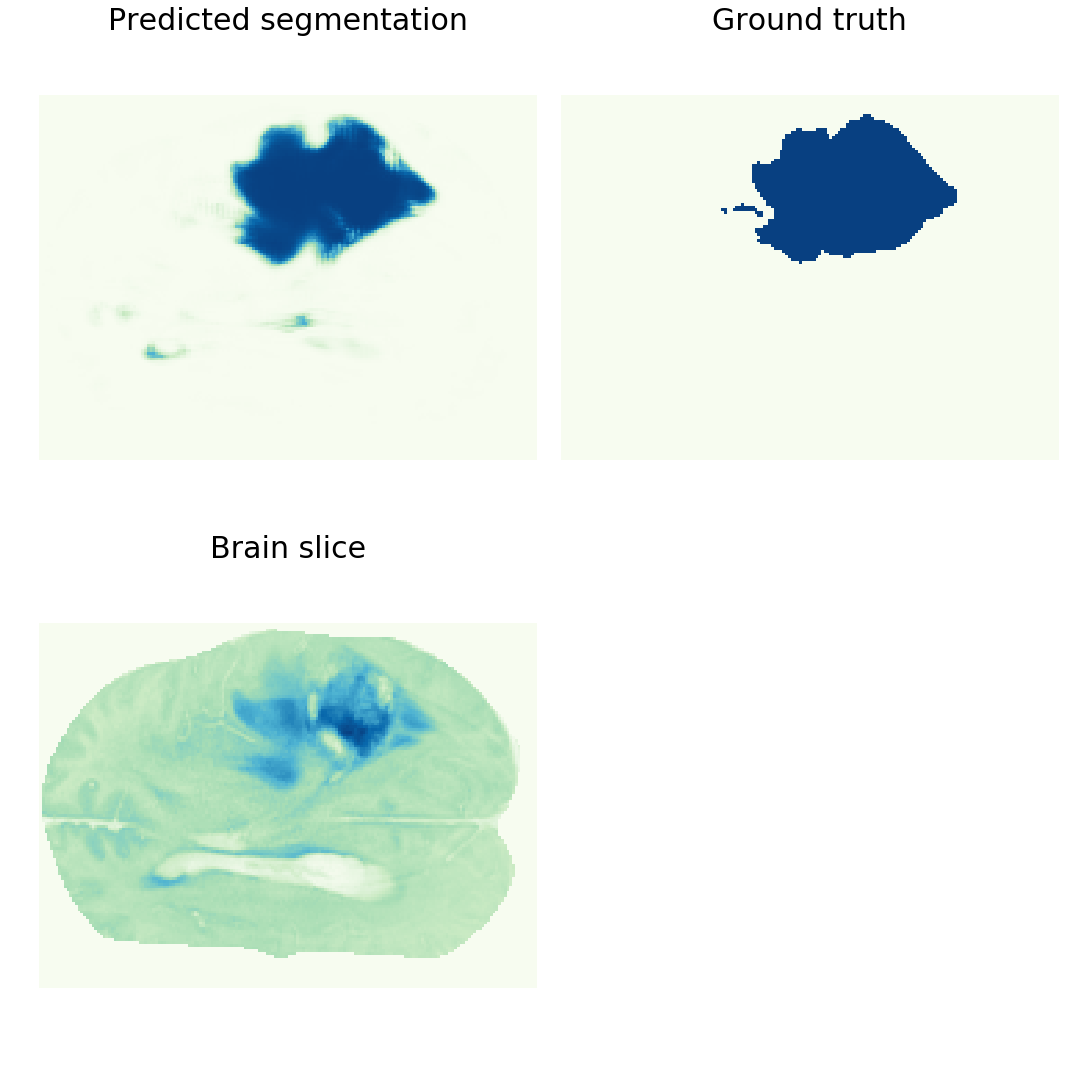

In [97]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))

i = 4
k = 90

cmap = cm.GnBu
fontsize = 30

ax[0, 0].set_title('Predicted segmentation', fontsize=fontsize)
ax[0, 0].imshow(y_preds_t[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].set_title('Ground truth', fontsize=fontsize)
ax[0, 1].imshow(msegms_test[i][0, ..., k], cmap=cmap)

ax[1,0].set_title('Brain slice', fontsize=fontsize)
ax[1, 0].imshow(mscans_test[i][3, ..., k], cmap=cmap)
plt.tight_layout()
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 1].axis('off')
plt.show()
#plt.colorbar()
#plt.show()

In [8]:
# def pred_reshape(y):
#     x = y.permute(0, 2, 3, 4, 1)
#     return x.contiguous().view(-1, x.size()[-1])

# def loss_cross_entropy(y_pred, y_true):
#     return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))


coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)